In [420]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties import unumpy
from scipy import odr
import pandas as pd

In [421]:
# amplitude fit
def res_LIA_Amplitude(beta, omega):
    omega_0, gamma, A, C = beta
    return (A/np.sqrt((omega_0**2 - omega**2)**2 + omega**2 * gamma**2)) + C

def fit_resonance_Amplitude(omega_u, R_V_u, p0, title="LIA"):
    model = odr.Model(res_LIA_Amplitude)
    data = odr.RealData(unumpy.nominal_values(omega_u), unumpy.nominal_values(R_V_u), sx=unumpy.std_devs(omega_u), sy=unumpy.std_devs(R_V_u))
    odr_run = odr.ODR(data, model, beta0=p0).run()

    omega0_fit, gamma_fit, A_fit, C_fit  = odr_run.beta
    omega0_err, gamma_err, A_err, C_err = odr_run.sd_beta

    omega_0 = ufloat(omega0_fit, omega0_err)
    gamma = ufloat(gamma_fit, gamma_err)
    A = ufloat(A_fit, A_err)
    C = ufloat(C_fit, C_err)

    # r2-score
    y_hat = res_LIA_Amplitude(odr_run.beta, unumpy.nominal_values(omega_u))
    ss_res = np.sum((unumpy.nominal_values(R_V_u) - y_hat)**2)
    ss_tot = np.sum((unumpy.nominal_values(R_V_u) - np.mean(unumpy.nominal_values(R_V_u)))**2)
    r_squared = 1.0 - ss_res/ss_tot

    # convert to Frequency
    f_0 = omega_0/(2*np.pi)

    # quality factor
    Q = omega_0/gamma

    print(f"f0 = {f_0:.2f} Hz")
    print(f"Gamma = {gamma:.2f} rad/s")
    print(f"Q = {Q:.2f}")

    # plot
    f_min, f_max = np.min(unumpy.nominal_values(omega_u)/(2*np.pi)), np.max(unumpy.nominal_values(omega_u)/(2*np.pi))
    f_pad = 0.05 * (f_max - f_min)
    f_fit = np.linspace(f_min - f_pad, f_max + f_pad, 1000)
    omega_fit = 2 * np.pi * f_fit

    R_fit  = res_LIA_Amplitude([omega0_fit, gamma_fit, A_fit, C_fit], omega_fit)

    plt.figure(figsize=(7.5, 5))
    plt.errorbar(unumpy.nominal_values(omega_u)/(2*np.pi), unumpy.nominal_values(R_V_u), xerr=unumpy.std_devs(omega_u)/(2*np.pi), yerr=unumpy.std_devs(R_V_u), fmt='o', capsize=3, label='Data')
    plt.plot(f_fit, R_fit, '-', label=rf"{title} fit")
    plt.xlabel('Frequency $f$ [Hz]')
    plt.ylabel('Voltage [mV]')
    plt.title(f'Resonance with {title} (R² = {r_squared:.5f})')

    # styling for legend and text box done by ChatGPT
    # Draw legend first (so it exists and we can read its style)
    legend = plt.legend(loc='upper right', fontsize=9, frameon=True, alignment='left')
    plt.tight_layout()

    # ---- Get legend box properties ----
    legend_box = legend.get_frame()
    legend_style = dict(
        boxstyle=f"{legend_box.get_boxstyle().__class__.__name__.lower()} ,pad=0.35",
        facecolor=legend_box.get_facecolor(),
        edgecolor=legend_box.get_edgecolor(),
        linewidth=legend_box.get_linewidth()
    )

    # ---- Textbox content (ufloat compatible) ----
    text_box = '\n'.join((
        rf'$f_0 = ({f_0.n:.2f} \pm {f_0.s:.2f}) \,\mathrm{{Hz}}$',
        rf'$\Gamma = ({gamma.n:.1f} \pm {gamma.s:.1f})\,\mathrm{{rad/s}}$',
        rf'$A = ({A.n/100000:.0f} \pm {A.s/100000:.0f})\cdot 10^5 \, \mathrm{{m/s^2}}$',
        rf'$C = ({C.n:.2f} \pm {C.s:.2f}) \, \mathrm{{mV}}$',
    ))

    # ---- Add matching text box ----
    plt.text(
        0.725, # x
        0.67, # y
        text_box,
        transform=plt.gca().transAxes,
        fontsize=9,
        verticalalignment='bottom',
        bbox=legend_style,
    )

    plt.savefig(f'resonance_{title}_amplitude.png', dpi=600)
    plt.show()

In [422]:
# phase fit
def res_LIA_Phase(beta, omega):
    omega_0, gamma, phi = beta
    return -np.arctan2(omega * gamma , omega_0**2 - omega**2) +  phi

def fit_resonance_phase(omega_u, Phase_rad_u, p0, title="LIA"):
    model = odr.Model(res_LIA_Phase)
    data = odr.RealData(unumpy.nominal_values(omega_u), unumpy.nominal_values(Phase_rad_u), sx=unumpy.std_devs(omega_u), sy=unumpy.std_devs(Phase_rad_u))
    odr_run = odr.ODR(data, model, beta0=p0).run()

    omega0_fit, gamma_fit, phi_fit  = odr_run.beta
    omega0_err, gamma_err, phi_err_fit = odr_run.sd_beta

    omega_0 = ufloat(omega0_fit, omega0_err)
    gamma = ufloat(gamma_fit, gamma_err)
    phi = ufloat(phi_fit, phi_err_fit)

    # r2-score
    y_hat = res_LIA_Phase(odr_run.beta, unumpy.nominal_values(omega_u))
    ss_res = np.sum((unumpy.nominal_values(Phase_rad_u) - y_hat)**2)
    ss_tot = np.sum((unumpy.nominal_values(Phase_rad_u) - np.mean(unumpy.nominal_values(Phase_rad_u)))**2)
    r_squared = 1.0 - ss_res/ss_tot

    # convert to Frequency
    f_0 = omega_0/(2*np.pi)

    print(f"f0 = {f_0:.2f} Hz")
    print(f"Gamma = {gamma:.2f} rad/s")

    # plot
    f_min, f_max = np.min(unumpy.nominal_values(omega_u)/(2*np.pi)), np.max(unumpy.nominal_values(omega_u)/(2*np.pi))
    f_pad = 0.05 * (f_max - f_min)
    f_fit = np.linspace(f_min - f_pad, f_max + f_pad, 1000)
    omega_fit = 2 * np.pi * f_fit

    Phase_fit  = res_LIA_Phase([omega0_fit, gamma_fit, phi_fit], omega_fit)
    Phase_p0 = res_LIA_Phase(p0, omega_fit)

    plt.figure(figsize=(7.5, 5))
    plt.errorbar(unumpy.nominal_values(omega_u)/(2*np.pi), unumpy.nominal_values(Phase_rad_u), xerr=unumpy.std_devs(omega_u)/(2*np.pi), yerr=unumpy.std_devs(Phase_rad_u), fmt='o', capsize=3, label='Data')
    plt.plot(f_fit, Phase_fit, '-', label=rf"{title} fit")
    plt.plot(f_fit, Phase_p0, '-', label=rf"p_0fit")
    plt.xlabel('Frequency $f$ [Hz]')
    plt.ylabel('Phase [rad]')
    plt.title(f'Resonance with {title} (R² = {r_squared:.5f})')

    # styling for legend and text box done by ChatGPT
    # Draw legend first (so it exists and we can read its style)
    legend = plt.legend(loc='upper right', fontsize=9, frameon=True, alignment='left')
    plt.tight_layout()

    # ---- Get legend box properties ----
    legend_box = legend.get_frame()
    legend_style = dict(
        boxstyle=f"{legend_box.get_boxstyle().__class__.__name__.lower()} ,pad=0.35",
        facecolor=legend_box.get_facecolor(),
        edgecolor=legend_box.get_edgecolor(),
        linewidth=legend_box.get_linewidth()
    )

    # ---- Textbox content (ufloat compatible) ----
    text_box = '\n'.join((
        rf'$f_0 = ({f_0.n:.2f} \pm {f_0.s:.2f})\,\mathrm{{Hz}}$',
        rf'$\Gamma = ({gamma.n:.1f} \pm {gamma.s:.1f})\,\mathrm{{rad/s}}$',
        rf'$\phi = ({phi.n:.3f} \pm {phi.s:.3f})\,\mathrm{{rad}}$'
    ))

    # ---- Add matching text box ----
    plt.text(
        0.77, # x
        0.72, # y
        text_box,
        transform=plt.gca().transAxes,
        fontsize=9,
        verticalalignment='bottom',
        bbox=legend_style,
    )

    plt.savefig(f'resonance_{title}_phase.png', dpi=600)
    plt.show()

# Resonance using Lock-in Amplifier

f0 = 835.65+/-0.60 Hz
Gamma = 42.58+/-2.75 rad/s
Q = 123.31+/-7.97


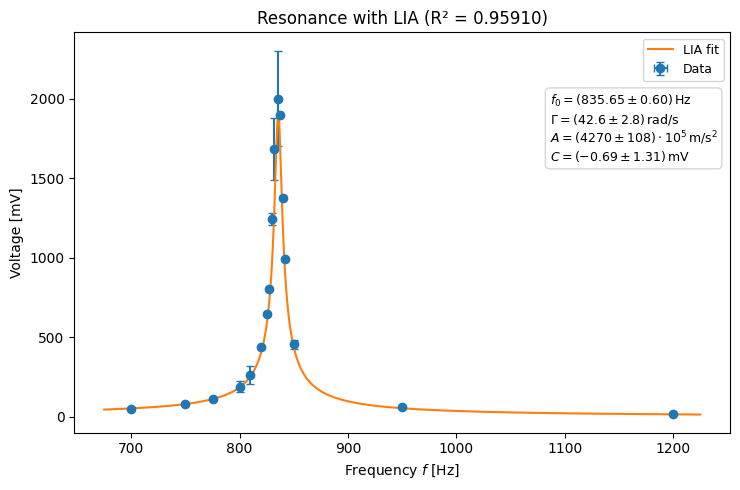

f0 = 832.78+/-0.73 Hz
Gamma = 8.89+/-1.51 rad/s


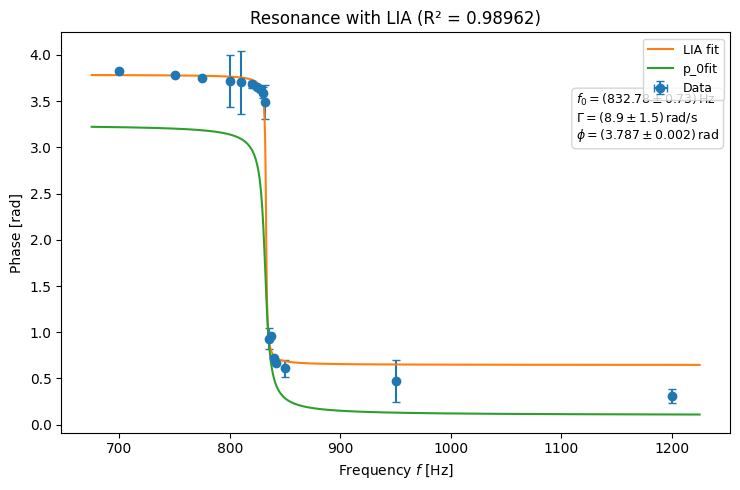

In [423]:
# adjust frequency in Hz
f = np.array([700, 750, 775, 800, 810, 820, 825, 827, 830, 832, 835, 837, 840, 842, 850, 950, 1200]) # Hz
omega_u = unumpy.uarray(f, np.full(len(f), 0.5)) * (2 * np.pi)

X_val = np.array([37.86, 62.74, 90.81, 158.2, 223.2, 374.9, 564.7, 708.6, 1119.0, 1579.0, 1197, 1091.0, 1035, 775.6, 374.1, 52.36, 15.42]) # mV
X_err = np.array([0.015, 0.02414, 0.0580, 0.1778, 0.05785, 0.06812, 0.05998, 0.4468, 0.09500, 170.8, 4.110, 0.1003, 0.7362, 0.05924, 0.07751, 0.021, 0.064]) # mV
X_mV_u = unumpy.uarray(X_val, X_err)

Y_val = np.array([31.14, 46.41, 63.56, 103.5, 140.5, 224.3, 315.4, 376.7, 540.9, 578.9, 1603.0, 1549.0, 909.2, 615.1, 260.7, 26.56, 4.876]) #mV
Y_err = np.array([0.653, 0.01557, 1.5, 63.78, 107.3, 18.69, 18.28, 0.121, 84.43, 328.3, 376.6, 0.07609, 17.07, 15.2, 49.77, 15.01, 1.298]) # mV
Y_mV_u = unumpy.uarray(Y_val, Y_err)

# convert to polar coordinates
theta_rad_calc_u = unumpy.arctan(Y_mV_u / X_mV_u)
#theta_rad_calc_u[:10] = theta_rad_calc_u[:10] - np.mean(theta_rad_calc_u[:10])
theta_rad_calc_u[:10] = theta_rad_calc_u[:10] + np.pi # unwrap "by hand"

R_mV_calc_u = unumpy.sqrt(X_mV_u**2 + Y_mV_u**2)

# fit
p0 = [2*np.pi*832.8, 162, 1100000000, 830]
fit_resonance_Amplitude(omega_u, R_mV_calc_u, p0)

p0 = [2*np.pi*832, 42, np.pi+0.1]
fit_resonance_phase(omega_u, theta_rad_calc_u, p0)

# Resonance using frequency analyser

In [424]:
# conversion from dB to V
def dBm_to_Vpp(data):
    return 10**(data/20)

# uncertainty approximation
def uncertainty_approx(x):
    s = str(x).strip()
    if "." in s:
        decimals = len(s.split(".")[1])
        return 0.5 * 10**(-decimals)
    else:
        return 0.5 # keine Nachkommastellen

f0 = 836.19+/-0.05 Hz
Gamma = 44.50+/-0.49 rad/s
Q = 118.06+/-1.29


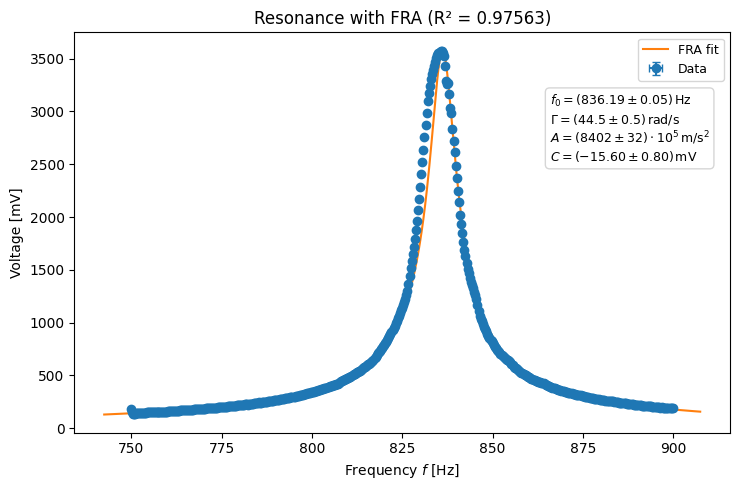

f0 = 835.26+/-916265.28 Hz
Gamma = 0.04+/-1684.49 rad/s


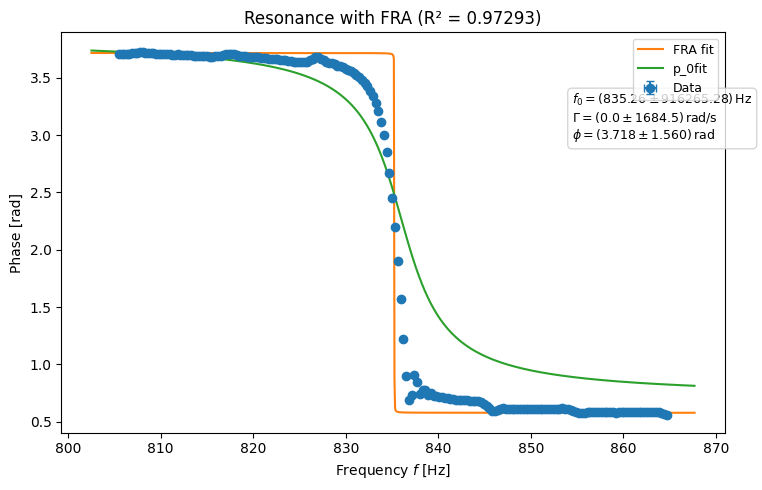

In [425]:
file_path = "sweep.csv"
df = pd.read_csv(file_path, comment="%", sep=",", header=None, names=["Time (Hz)", "Magnitude (dB)", "Phase (deg)"]) # dateien einlesen

cols = ["Magnitude (dB)", "Phase (deg)"]
df[cols] = df[cols].apply(lambda col: pd.to_numeric(col.astype(str).str.strip(), errors="coerce")) # get rid of spaces and convert anything to numbers

data = df.dropna(subset=["Magnitude (dB)", "Phase (deg)"])
f_Hz = np.array(data["Time (Hz)"].values)
A_dBm = np.array(data["Magnitude (dB)"].values)
Phase_deg = np.array(data["Phase (deg)"].values)

# conversions
A_V = dBm_to_Vpp(A_dBm) # convert dB to V
Phase_rad = (Phase_deg * np.pi / 180) % (2 * np.pi) # convert deg to rad

f_Hz_err = np.array([uncertainty_approx(i) for i in f_Hz])
A_V_err = np.array([uncertainty_approx(i) for i in A_V])
Phase_rad_err = np.array(([uncertainty_approx(i) for i in Phase_rad]))

omega_u = unumpy.uarray(f_Hz, f_Hz_err) * (2 * np.pi)
A_v_u = unumpy.uarray(A_V, A_V_err) * 1000 # convert to mV
Phase_rad_u = unumpy.uarray(Phase_rad, Phase_rad_err)

p0 = [2*np.pi*835, 100, 1157050000, 830]
fit_resonance_Amplitude(omega_u, A_v_u, p0, "FRA")

p0 = [2*np.pi*836, 44, np.pi+0.7]
fit_resonance_phase(omega_u[200:400], Phase_rad_u[200:400], p0, "FRA")

# Ringdown

In [449]:
def ringdown(beta, t):
    A, gamma, C = beta
    return A * np.exp(-gamma/2 * t) + C

def fit_ringdown(t_u, A_V_u, p0):
    model = odr.Model(ringdown)
    data = odr.RealData(unumpy.nominal_values(t_u), unumpy.nominal_values(A_V_u), sx=unumpy.std_devs(t_u), sy=unumpy.std_devs(A_V_u))
    odr_run = odr.ODR(data, model, beta0=p0).run()

    A_fit, gamma_fit, C_fit = odr_run.beta
    A_err, gamma_err, C_err = odr_run.sd_beta

    A = ufloat(A_fit, A_err)
    gamma = ufloat(gamma_fit, gamma_err)

    # r2-score
    y_hat = ringdown(odr_run.beta, unumpy.nominal_values(t_u))
    ss_res = np.sum((unumpy.nominal_values(A_V_u) - y_hat)**2)
    ss_tot = np.sum((unumpy.nominal_values(A_V_u) - np.mean(unumpy.nominal_values(A_V_u)))**2)
    r_squared = 1.0 - ss_res/ss_tot

    print(f"Gamma = {gamma:.2f} rad/s")

    # plot
    t_min, t_max = np.min(unumpy.nominal_values(t_u)), np.max(unumpy.nominal_values(t_u))
    t_pad = 0.005 * (t_max - t_min)
    t_fit = np.linspace(t_min - t_pad, t_max + t_pad, 1000)

    A_fit  = ringdown([A_fit, gamma_fit, C_fit], t_fit)
    A_p0 = ringdown(p0, t_fit)

    plt.figure(figsize=(7.5, 5))
    plt.errorbar(unumpy.nominal_values(t_u), unumpy.nominal_values(A_V_u), xerr=unumpy.std_devs(t_u), yerr=unumpy.std_devs(A_V_u), fmt='o', capsize=3, label='Data')
    plt.plot(t_fit, A_fit, '-', label=rf"Ringdown fit")
    #plt.plot(t_fit, A_p0, '-', label=rf"p0 fit")
    plt.xlabel('Times [s]')
    plt.ylabel('Voltage [V]')
    plt.title(f'ringdown (R² = {r_squared:.5f})')

    # styling for legend and text box done by ChatGPT
    # Draw legend first (so it exists and we can read its style)
    legend = plt.legend(loc='upper right', fontsize=9, frameon=True, alignment='left')
    plt.tight_layout()

    # ---- Get legend box properties ----
    legend_box = legend.get_frame()
    legend_style = dict(
        boxstyle=f"{legend_box.get_boxstyle().__class__.__name__.lower()} ,pad=0.35",
        facecolor=legend_box.get_facecolor(),
        edgecolor=legend_box.get_edgecolor(),
        linewidth=legend_box.get_linewidth()
    )

    # ---- Textbox content (ufloat compatible) ----
    text_box = '\n'.join((
        rf'$A = ({A.n:.2f} \pm {A.s:.2f}) \, \mathrm{{V}}$',
        rf'$\Gamma = ({gamma.n:.2f} \pm {gamma.s:.2f})\,\mathrm{{rad/s}}$',
    ))

    # ---- Add matching text box ----
    plt.text(
        0.725, # x
        0.67, # y
        text_box,
        transform=plt.gca().transAxes,
        fontsize=9,
        verticalalignment='bottom',
        bbox=legend_style,
    )

    plt.savefig(f'ringdown.png', dpi=600)
    plt.show()

C:\Users\Lorenz\AppData\Local\Temp\ipykernel_21020\785612273.py:3: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-gamma/2 * t) + C
C:\Users\Lorenz\AppData\Local\Temp\ipykernel_21020\785612273.py:3: RuntimeWarning: overflow encountered in multiply
  return A * np.exp(-gamma/2 * t) + C


Gamma = 6.39+/-0.05 rad/s


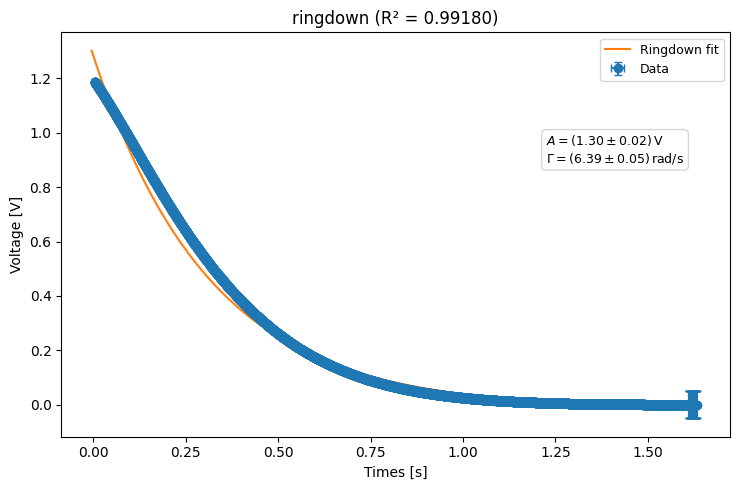

In [450]:
file_path = "ringdown_high.csv"
df = pd.read_csv(file_path, comment="%", sep=",", header=None, names=["Time (s)", "Probe A (V)", "Probe B (V)"]) # dateien einlesen

cols = ["Probe B (V)"]
df[cols] = df[cols].apply(lambda col: pd.to_numeric(col.astype(str).str.strip(), errors="coerce")) # get rid of spaces and convert anything to numbers

data = df.dropna(subset=["Probe B (V)"])
t = np.array(data["Time (s)"].values)
A_V = np.array(data["Probe B (V)"].values)

t_err = np.array([uncertainty_approx(i) for i in t])
A_V_err = np.array([uncertainty_approx(i) for i in A_V])

t_u = unumpy.uarray(t, t_err)
A_V_u = unumpy.uarray(A_V, A_V_err)

p0 = [1,20,1]
fit_ringdown(t_u[15341:20000], A_V_u[15341:20000], p0)
#fit_ringdown(t_u[425:725], A_V_u[425:725], p0)